Image fat.jpg - Fat Area: 39.97%


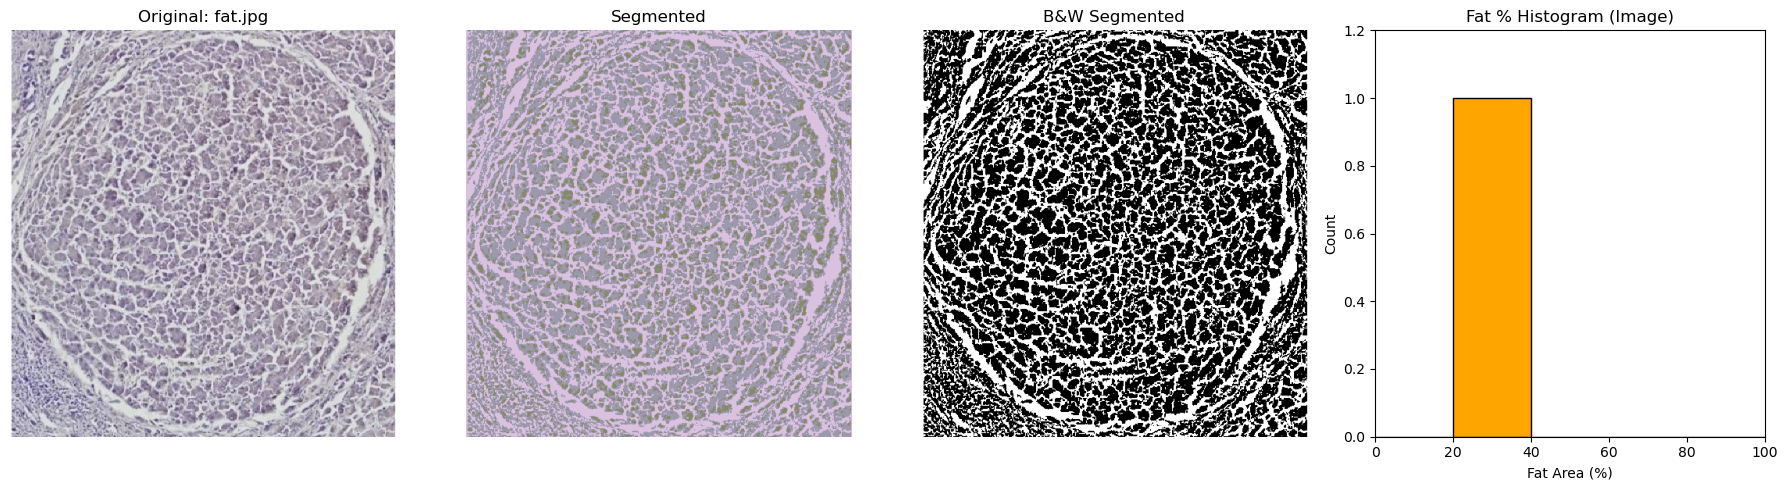

Image fat2.jpg - Fat Area: 42.33%


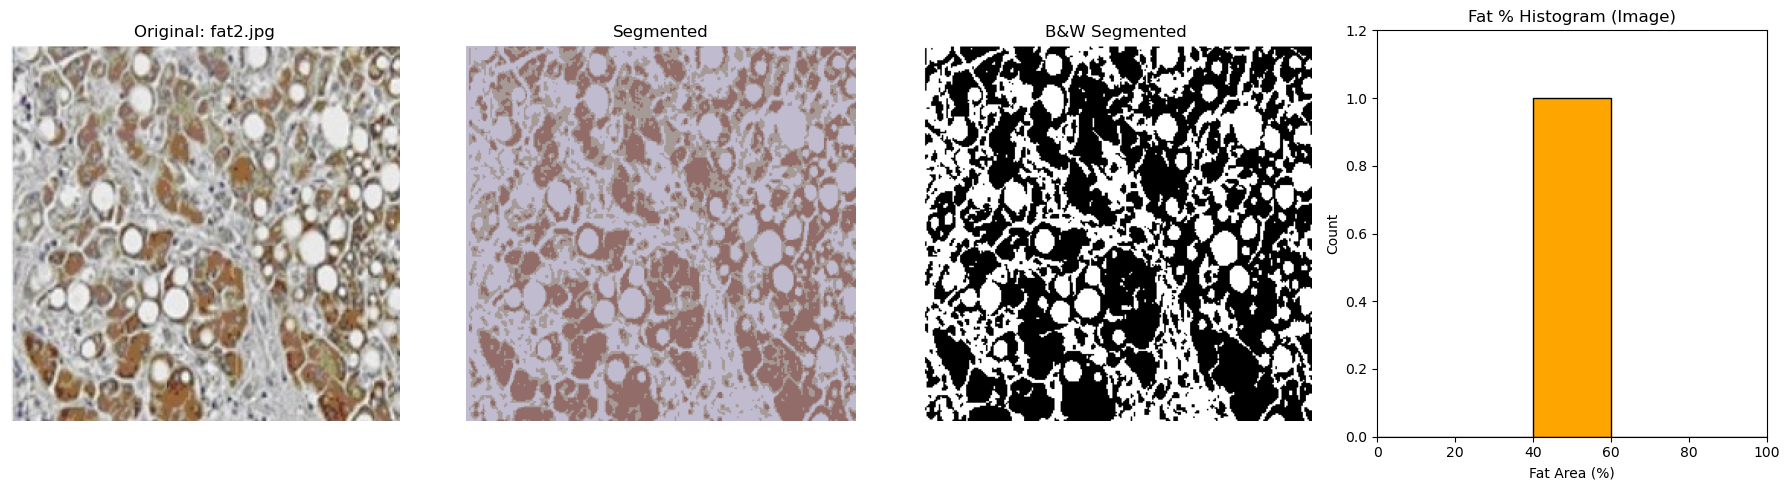

Image fat3.png - Fat Area: 39.33%


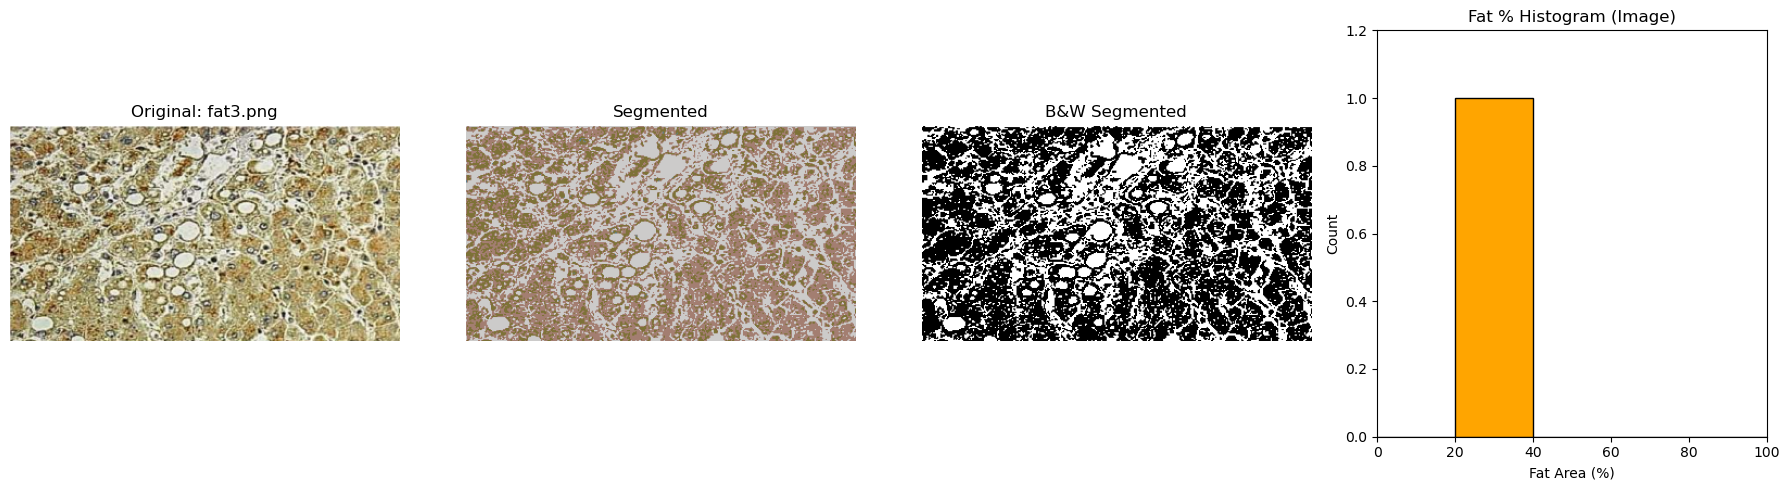

Image fat4.png - Fat Area: 54.95%


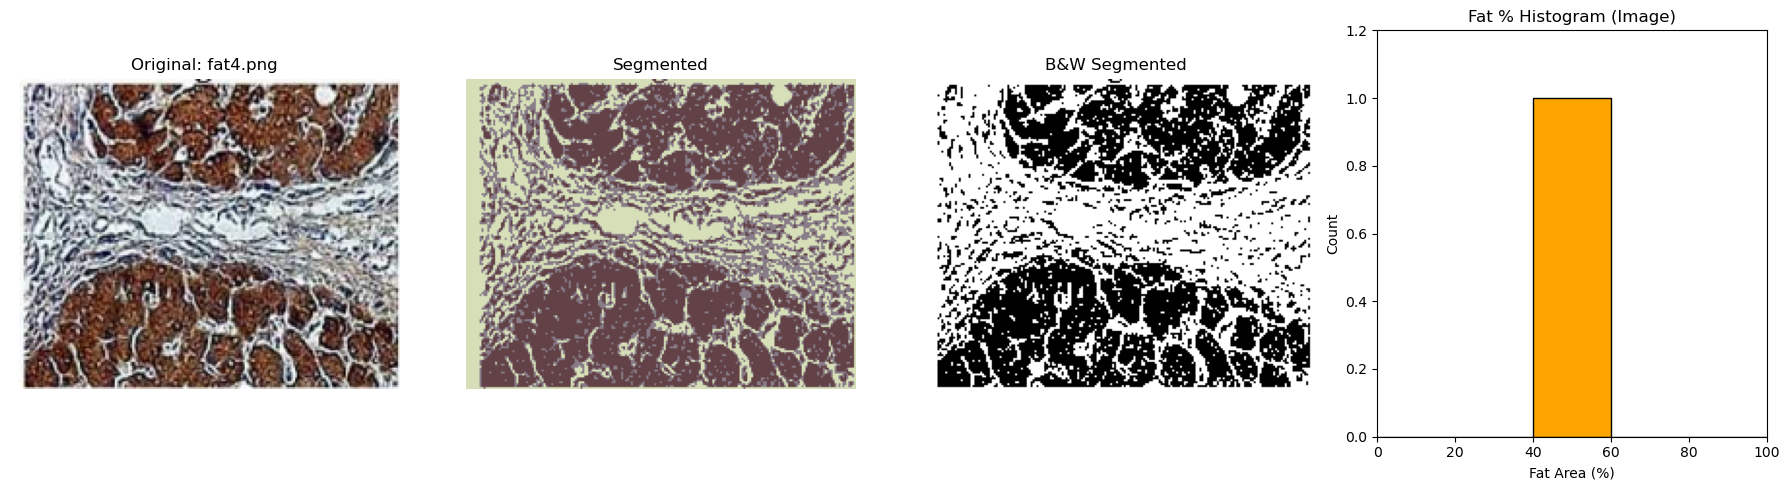

Image fat5.png - Fat Area: 23.54%


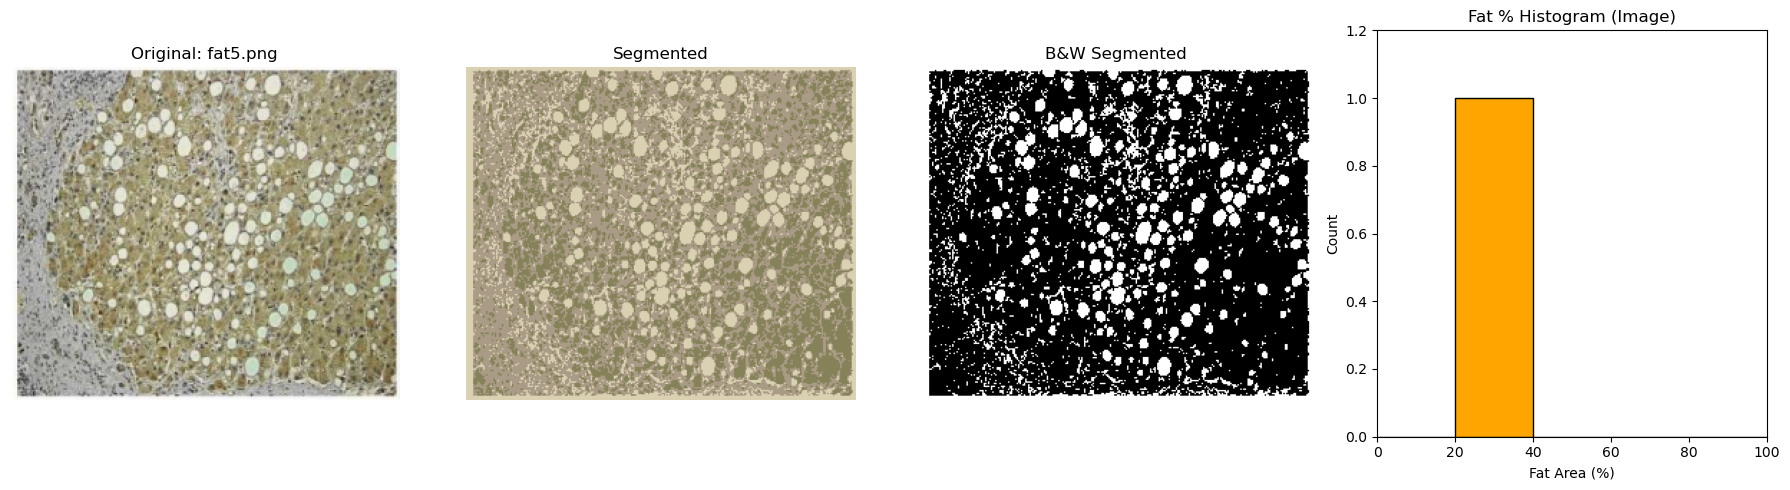

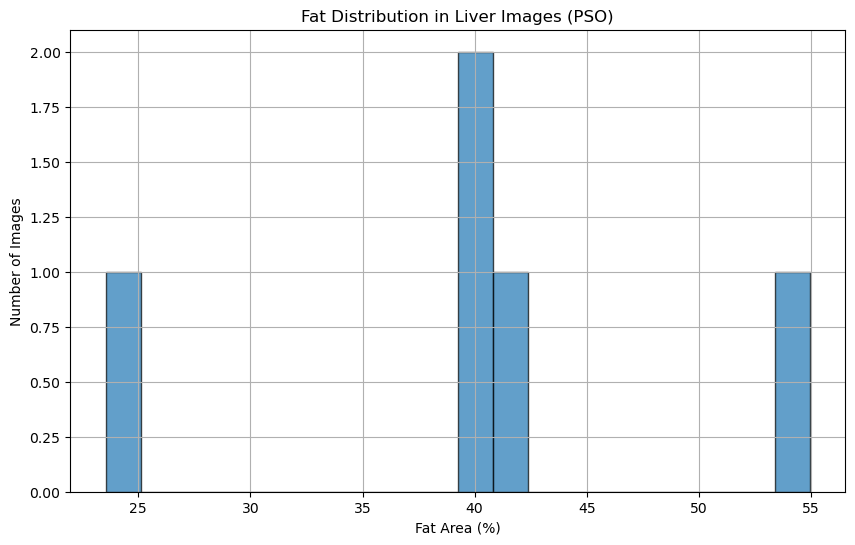


Fat Area Summary Table:
Filename  Fat Area (%)
 fat.jpg     39.965575
fat2.jpg     42.325089
fat3.png     39.328957
fat4.png     54.950249
fat5.png     23.543674


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

# --- PSO Segmentation Function ---
def pso_segment(image_array, n_segments, n_particles=30, n_iterations=30):
    height, width, channels = image_array.shape
    flat_image = image_array.reshape((-1, channels))

    particles = np.random.rand(n_particles, n_segments, channels) * 255
    velocities = np.random.randn(n_particles, n_segments, channels) * 0.1
    personal_best = np.copy(particles)
    global_best = np.copy(particles[np.random.randint(n_particles)])
    global_best_fitness = float('inf')

    def fitness(particle):
        distances = np.linalg.norm(flat_image[:, None, :] - particle, axis=2)
        labels = np.argmin(distances, axis=1)
        sse = 0
        for i in range(n_segments):
            cluster = flat_image[labels == i]
            if len(cluster) > 0:
                sse += np.sum(np.linalg.norm(cluster - particle[i], axis=1) ** 2)
        return sse

    w = 0.7
    c1 = 1.5
    c2 = 1.5

    for iter in range(n_iterations):
        for i in range(n_particles):
            inertia = w * velocities[i]
            cognitive = c1 * np.random.rand() * (personal_best[i] - particles[i])
            social = c2 * np.random.rand() * (global_best - particles[i])
            velocities[i] = inertia + cognitive + social
            particles[i] += velocities[i]

            curr_fit = fitness(particles[i])
            personal_fit = fitness(personal_best[i])

            if curr_fit < personal_fit:
                personal_best[i] = particles[i]
            if curr_fit < global_best_fitness:
                global_best = particles[i]
                global_best_fitness = curr_fit

    return global_best, None

def apply_segmentation(image_array, centroids):
    flat_image = image_array.reshape((-1, image_array.shape[2]))
    distances = np.linalg.norm(flat_image[:, None, :] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    segmented = centroids[labels].reshape(image_array.shape)
    return segmented.astype(np.uint8)

def to_black_and_white(image):
    gray = np.mean(image, axis=2)
    bw = (gray > gray.mean()).astype(np.uint8) * 255
    return bw

def process_image_folder_pso(folder_path, n_segments=4, n_particles=30, n_iterations=30):
    fat_areas = []
    filenames = []

    for file in os.listdir(folder_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        try:
            path = os.path.join(folder_path, file)
            image = np.array(Image.open(path).convert('RGB'))

            centroids, _ = pso_segment(image, n_segments, n_particles, n_iterations)
            segmented = apply_segmentation(image, centroids)
            bw_segmented = to_black_and_white(segmented)

            fat_pixels = np.sum(bw_segmented == 255)
            total_pixels = bw_segmented.size
            fat_pct = (fat_pixels / total_pixels) * 100
            fat_areas.append(fat_pct)
            filenames.append(file)

            print(f"Image {file} - Fat Area: {fat_pct:.2f}%")

            plt.figure(figsize=(18,5))

            plt.subplot(1,4,1)
            plt.imshow(image)
            plt.title(f'Original: {file}')
            plt.axis('off')

            plt.subplot(1,4,2)
            plt.imshow(segmented)
            plt.title('Segmented')
            plt.axis('off')

            plt.subplot(1,4,3)
            plt.imshow(bw_segmented, cmap='gray')
            plt.title('B&W Segmented')
            plt.axis('off')

            plt.subplot(1,4,4)
            plt.hist([fat_pct], bins=5, range=(0,100), color='orange', edgecolor='black')
            plt.title('Fat % Histogram (Image)')
            plt.xlabel('Fat Area (%)')
            plt.ylabel('Count')
            plt.xlim(0, 100)
            plt.ylim(0, 1.2)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {file}: {e}")

    # Show overall histogram of fat areas
    plt.figure(figsize=(10,6))
    plt.hist(fat_areas, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Fat Area (%)')
    plt.ylabel('Number of Images')
    plt.title('Fat Distribution in Liver Images (PSO)')
    plt.grid(True)
    plt.show()

    # Create and print table of results
    df = pd.DataFrame({'Filename': filenames, 'Fat Area (%)': fat_areas})
    print("\nFat Area Summary Table:")
    print(df.to_string(index=False))

    return fat_areas

# --- Run ---
folder_path = r'C:\Users\pc\Desktop\fatty lever data'
fat_areas_pso = process_image_folder_pso(folder_path)
